In [1]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Netflix Media Counts by Happiness Index

In [2]:
# File to Load Netflix Metacritic Data
file_to_load = 'Data Sets/Latest Netflix data with 26+ joined attributes/netflix-rotten-tomatoes-metacritic-imdb.csv'
netflix_metacritic = pd.read_csv(file_to_load)

# File to Load Happiness Report Data
file_to_load_h = 'Data Sets/World Happiness Report/world-happiness-report-2021.csv'
world_happiness_report = pd.read_csv(file_to_load_h)

world_happiness_report.head()
world_happiness_report_sub = world_happiness_report[['Country name','Regional indicator','Ladder score']]
world_happiness_report_sub.columns = ['Country','Region','Ladder Score']
world_happiness_report_sub

,Country,Region,Ladder Score
0,Finland,Western Europe,7.842
1,Denmark,Western Europe,7.620
2,Switzerland,Western Europe,7.571
3,Iceland,Western Europe,7.554
4,Netherlands,Western Europe,7.464
...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512
145,Botswana,Sub-Saharan Africa,3.467
146,Rwanda,Sub-Saharan Africa,3.415
147,Zimbabwe,Sub-Saharan Africa,3.145


In [3]:
# Create a subset of netflix metacritic data to include only necessary data
netflix_metacritic.head()
netflix_metacritic_subset = netflix_metacritic[['Title','Genre','Languages','Country Availability','Director', 'Series or Movie']]
netflix_metacritic_subset.columns = ['Title','Genre','Languages','Country','Director','Series or Movie']

# Explode country availability column into rows and create a dataframe
netflix_country_split = netflix_metacritic_subset.Country.str.split(',')
series = netflix_country_split.apply(pd.Series, 1)
stacked = series.stack()
drop = stacked.index = stacked.index.droplevel(-1)
df = pd.DataFrame(stacked)
df = df.join(netflix_metacritic_subset)
del df['Country']
df.columns = ['Country','Title','Genre','Languages','Director','Media Type']
df = df.reset_index(drop=True)
df.to_csv('Data Sets/G3_Netflix_by_Country.csv', index = False)
df

,Country,Title,Genre,Languages,Director,Media Type
0,Thailand,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Swedish, Spanish",Tomas Alfredson,Series
1,Canada,HOW TO BUILD A GIRL,Comedy,English,Coky Giedroyc,Movie
2,Canada,Centigrade,"Drama, Thriller",English,Brendan Walsh,Movie
3,Belgium,ANNE+,Drama,Turkish,NaN,Series
4,Netherlands,ANNE+,Drama,Turkish,NaN,Series
...,...,...,...,...,...,...
195580,Brazil,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series
195581,Netherlands,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series
195582,Italy,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series
195583,Israel,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series


In [4]:
# create a dataframe containing media type counts by country
media_bycountry = df.groupby(['Country','Media Type'])['Title'].nunique()
media_bycountry = pd.DataFrame(media_bycountry)
media_bycountry = media_bycountry.reset_index()
media_bycountry

,Country,Media Type,Title
0,Argentina,Movie,3356
1,Argentina,Series,1754
2,Australia,Movie,3721
3,Australia,Series,2066
4,Belgium,Movie,3580
...,...,...,...
67,Turkey,Series,1737
68,United Kingdom,Movie,4102
69,United Kingdom,Series,2171
70,United States,Movie,3633


In [5]:
# create a dataframe that merges netflix data with happiness score by country
happynetflix_merge = pd.merge(media_bycountry, world_happiness_report_sub, on='Country',how='inner')
happynetflix_merge.columns = ['Country','Media Type','Media Count','Region','Happiness Score']
happynetflix_merge = happynetflix_merge[['Region','Country','Happiness Score','Media Type','Media Count']]
happynetflix_merge

,Region,Country,Happiness Score,Media Type,Media Count
0,Latin America and Caribbean,Argentina,5.929,Movie,3356
1,Latin America and Caribbean,Argentina,5.929,Series,1754
2,North America and ANZ,Australia,7.183,Movie,3721
3,North America and ANZ,Australia,7.183,Series,2066
4,Western Europe,Belgium,6.834,Movie,3580
...,...,...,...,...,...
65,Middle East and North Africa,Turkey,4.948,Series,1737
66,Western Europe,United Kingdom,7.064,Movie,4102
67,Western Europe,United Kingdom,7.064,Series,2171
68,North America and ANZ,United States,6.951,Movie,3633


In [6]:
# create a subset of netflix data for movies only
media_bycountry = happynetflix_merge[['Country','Happiness Score','Media Type','Media Count']]
movies_bycountry = media_bycountry[media_bycountry['Media Type'] == 'Movie']
movies_byhappy = pd.merge(movies_bycountry,world_happiness_report_sub,on=['Country'], how='outer')
movies_byhappy = movies_byhappy.drop('Happiness Score', axis=1)
movies_byhappy.columns = ['Country','Media Type','Media Count','Region','Happiness Score']
movies_byhappy = movies_byhappy.sort_values('Happiness Score', ascending = False)
movies_byhappy

# create a subset of netflix data for tv shows only
tv_bycountry = media_bycountry[media_bycountry['Media Type'] == 'Series']
tv_byhappy = pd.merge(tv_bycountry,world_happiness_report_sub,on=['Country'], how='outer')
tv_byhappy = tv_byhappy.drop('Happiness Score', axis=1)
tv_byhappy.columns = ['Country','Media Type','Media Count','Region','Happiness Score']
tv_byhappy = tv_byhappy.sort_values('Happiness Score', ascending = False)
tv_byhappy

,Country,Media Type,Media Count,Region,Happiness Score
35,Finland,NaN,NaN,Western Europe,7.842
36,Denmark,NaN,NaN,Western Europe,7.620
30,Switzerland,Series,1932.0,Western Europe,7.571
11,Iceland,Series,1944.0,Western Europe,7.554
19,Netherlands,Series,1753.0,Western Europe,7.464
...,...,...,...,...,...
144,Lesotho,NaN,NaN,Sub-Saharan Africa,3.512
145,Botswana,NaN,NaN,Sub-Saharan Africa,3.467
146,Rwanda,NaN,NaN,Sub-Saharan Africa,3.415
147,Zimbabwe,NaN,NaN,Sub-Saharan Africa,3.145


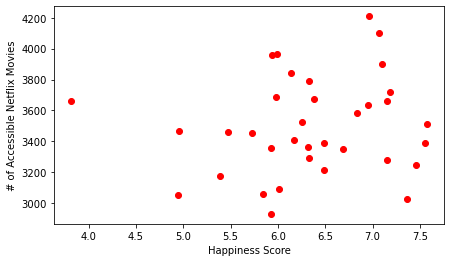

In [7]:
# select x and y values for plotting
y_values = movies_byhappy['Media Count']
x_values = movies_byhappy['Happiness Score']

# create scatter plot of accessible netflix movies by happiness score
fig = plt.subplots(figsize=(7,4))
plt.rc('font', size=12) 
movie_plot = plt.scatter(x_values,y_values,c='red')

# format labels properly
plt.ylabel('# of Accessible Netflix Movies')
plt.xlabel('Happiness Score')

plt.savefig('Images/Movies_byHappinessScore.png')

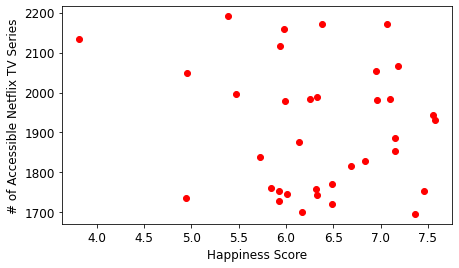

In [8]:
# select x and y values for plotting
y_values = tv_byhappy['Media Count']
x_values = tv_byhappy['Happiness Score']

# create scatter plot of accessible netflix tv series by happiness score
fig = plt.subplots(figsize=(7,4))
plt.rc('font', size=12)
plt.scatter(x_values,y_values, c='red')

# format labels properly
plt.ylabel('# of Accessible Netflix TV Series')
plt.xlabel('Happiness Score')

plt.savefig('Images/TVSeries_byHappinessScore.png')

In [9]:
netflix_metacritic.head()
netflix_metacritic_subset = netflix_metacritic[['Title','Genre','Languages','Country Availability','Director', 'Series or Movie','IMDb Score']]
netflix_metacritic_subset.columns = ['Title','Genre','Languages','Country','Director','Series or Movie','IMDb Score']

netflix_country_split = netflix_metacritic_subset.Country.str.split(',')
series = netflix_country_split.apply(pd.Series, 1)
stacked = series.stack()
drop = stacked.index = stacked.index.droplevel(-1)
df = pd.DataFrame(stacked)
df = df.join(netflix_metacritic_subset)
del df['Country']
df.columns = ['Country','Title','Genre','Languages','Director','Media Type','IMDb Score']
df = df.reset_index(drop=True)
df.to_csv('Data Sets/G3_Netflix_by_Country_IMDb.csv', index = False)
df

,Country,Title,Genre,Languages,Director,Media Type,IMDb Score
0,Thailand,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Swedish, Spanish",Tomas Alfredson,Series,7.9
1,Canada,HOW TO BUILD A GIRL,Comedy,English,Coky Giedroyc,Movie,5.8
2,Canada,Centigrade,"Drama, Thriller",English,Brendan Walsh,Movie,4.3
3,Belgium,ANNE+,Drama,Turkish,NaN,Series,6.5
4,Netherlands,ANNE+,Drama,Turkish,NaN,Series,6.5
...,...,...,...,...,...,...,...
195580,Brazil,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series,6.2
195581,Netherlands,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series,6.2
195582,Italy,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series,6.2
195583,Israel,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series,6.2


In [10]:
#File to Load
file_to_load = 'Data Sets/G3_Netflix_by_Country_IMDb.csv'
netflix_IMDb = pd.read_csv(file_to_load)
netflix_IMDb.head()

,Country,Title,Genre,Languages,Director,Media Type,IMDb Score
0,Thailand,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Swedish, Spanish",Tomas Alfredson,Series,7.9
1,Canada,HOW TO BUILD A GIRL,Comedy,English,Coky Giedroyc,Movie,5.8
2,Canada,Centigrade,"Drama, Thriller",English,Brendan Walsh,Movie,4.3
3,Belgium,ANNE+,Drama,Turkish,NaN,Series,6.5
4,Netherlands,ANNE+,Drama,Turkish,NaN,Series,6.5


In [11]:
IMDb_bycountry = df.groupby('Country')['IMDb Score'].mean()
IMDb_bycountry = pd.DataFrame(IMDb_bycountry)
IMDb_bycountry = IMDb_bycountry.reset_index()
IMDb_bycountry.columns = ['Country', 'Average IMDb Score']
IMDb_bycountry

,Country,Average IMDb Score
0,Argentina,6.562972
1,Australia,6.570967
2,Belgium,6.585095
3,Brazil,6.553182
4,Canada,6.552189
5,Colombia,6.553269
6,Czech Republic,6.559986
7,France,6.599128
8,Germany,6.584393
9,Greece,6.576955


In [12]:
IMDb_bycountry.describe()

,Average IMDb Score
count,36.000000
mean,6.587701
std,0.029409
min,6.543348
25%,6.566250
50%,6.584400
75%,6.601170
max,6.675830


In [13]:
happycountry = world_happiness_report[['Country name', 'Ladder score']]
happycountry.columns = ['Country','Ladder score']
happycountry

,Country,Ladder score
0,Finland,7.842
1,Denmark,7.620
2,Switzerland,7.571
3,Iceland,7.554
4,Netherlands,7.464
...,...,...
144,Lesotho,3.512
145,Botswana,3.467
146,Rwanda,3.415
147,Zimbabwe,3.145


In [14]:
len(happycountry)

149

In [15]:
happyIMDb_merge = pd.merge(happycountry, IMDb_bycountry, on='Country',how='inner')
happyIMDb_merge = pd.DataFrame(happyIMDb_merge)
happyIMDb_merge

,Country,Ladder score,Average IMDb Score
0,Switzerland,7.571,6.593347
1,Iceland,7.554,6.574310
2,Netherlands,7.464,6.587577
3,Sweden,7.363,6.587994
4,Australia,7.183,6.570967
5,Israel,7.157,6.596137
6,Germany,7.155,6.584393
7,Canada,7.103,6.552189
8,United Kingdom,7.064,6.557044
9,Czech Republic,6.965,6.559986


In [16]:
len(happyIMDb_merge)

35

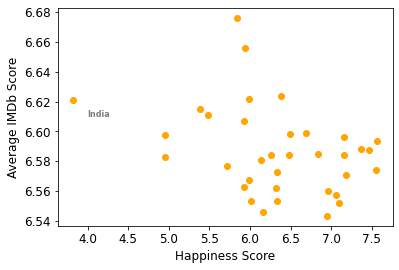

In [17]:
y_values = happyIMDb_merge['Average IMDb Score']
x_values = happyIMDb_merge['Ladder score']
plt.scatter(x_values,y_values, color = 'Orange')
plt.annotate(f'India',(4.0, 6.61), fontsize = 8 , color = 'Grey',fontweight = 'bold')
plt.xlabel('Happiness Score')
plt.ylabel('Average IMDb Score')

plt.show()

In [18]:
animation = netflix_IMDb['Genre'].str.contains('Animation') == True
ani_country = netflix_IMDb.loc[animation].groupby(['Country']).count()
ani_country

,Title,Genre,Languages,Director,Media Type,IMDb Score
Country,,,,,,
Argentina,591,591,553,199,591,569
Australia,607,607,566,230,607,586
Belgium,639,639,601,219,639,616
Brazil,575,575,538,194,575,557
Canada,617,617,578,221,617,603
Colombia,575,575,537,195,575,564
Czech Republic,568,568,531,201,568,546
France,652,652,616,228,652,631
Germany,593,593,555,202,593,574


In [19]:
len(ani_country)

36

In [20]:
happyani_merge = pd.merge(happycountry, ani_country, on='Country',how='inner')
happyani_merge = pd.DataFrame(happyani_merge)
happyani_merge

,Country,Ladder score,Title,Genre,Languages,Director,Media Type,IMDb Score
0,Switzerland,7.571,645,645,606,213,645,622
1,Iceland,7.554,502,502,464,164,502,481
2,Netherlands,7.464,570,570,533,186,570,551
3,Sweden,7.363,557,557,520,195,557,537
4,Australia,7.183,607,607,566,230,607,586
5,Israel,7.157,532,532,495,172,532,513
6,Germany,7.155,593,593,555,202,593,574
7,Canada,7.103,617,617,578,221,617,603
8,United Kingdom,7.064,639,639,596,229,639,616
9,Czech Republic,6.965,568,568,531,201,568,546


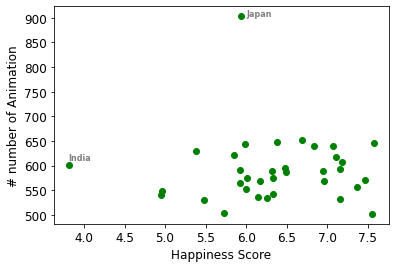

In [21]:
y_values = happyani_merge['Genre']
x_values = happyani_merge['Ladder score']
plt.scatter(x_values,y_values, color = 'Green')
plt.annotate(f'Japan',(6.0, 903), fontsize = 8 , color = 'Grey',fontweight = 'bold')
plt.annotate(f'India',(3.8, 612), fontsize = 8 , color = 'Grey',fontweight = 'bold')
plt.xlabel('Happiness Score')
plt.ylabel('# number of Animation')

plt.show()